In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import vstack
import cv2
from tensorflow.keras.preprocessing import image
from flask import Flask, request, jsonify
from PIL import Image
import io
from tensorflow.keras.models import load_model
import joblib
from sklearn.decomposition import PCA
import random
import os
from werkzeug.utils import secure_filename
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix, vstack, hstack
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
import cv2
import sounddevice as sd
import wavio
import numpy as np
import pickle
import os



TypeError: Descriptors cannot be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [16]:
##data loading
splits = {'test': 'informativeness/test.json', 'dev': 'informativeness/dev.json', 'train': 'informativeness/train.json'}
df_1 = pd.read_json("hf://datasets/QCRI/CrisisBench-all-lang/" + splits["test"])


splits1 = {'test': 'humanitarian/test.json', 'dev': 'humanitarian/dev.json', 'train': 'humanitarian/train.json'}
df_2 = pd.read_json("hf://datasets/QCRI/CrisisBench-all-lang/" + splits["test"])



In [17]:
#Creating Data_Frame
df1 = pd.DataFrame(df_1)
df2 = pd.DataFrame(df_2)

In [18]:

df1.replace('NA', np.nan, inplace=True)
df2.replace('NA', np.nan, inplace=True)

print(df1.isnull().sum())
print(df2.isnull().sum())


id                 0
event              0
source             0
text               0
lang               0
lang_conf      10171
class_label        0
dtype: int64
id                 0
event              0
source             0
text               0
lang               0
lang_conf      10171
class_label        0
dtype: int64


In [19]:
#dropping null values
df1.dropna(inplace=True)
df2.dropna(inplace=True)

In [28]:
#feature Engineering
le = LabelEncoder()
df1['lang_encoded'] = le.fit_transform(df1['lang'])
df2['lang_encoded'] = le.fit_transform(df2['lang'])

df1['City'] = df1['event'].apply(lambda x: x.split('_')[1].lower())
df2['City'] = df2['event'].apply(lambda x: x.split('_')[1].lower())

df1 = df1[df1['City'] != 'events']
df2 = df2[df2['City'] != 'events']

df1['Output'] = le.fit_transform(df1['class_label'])
df2['Output'] = le.fit_transform(df2['class_label'])

df1['City_encoded'] = le.fit_transform(df1['City'])
df2['City_encoded'] = le.fit_transform(df2['City'])

df1['lang_encoder'] = le.fit_transform(df1['lang'])
df2['lang_encoder'] = le.fit_transform(df2['lang'])


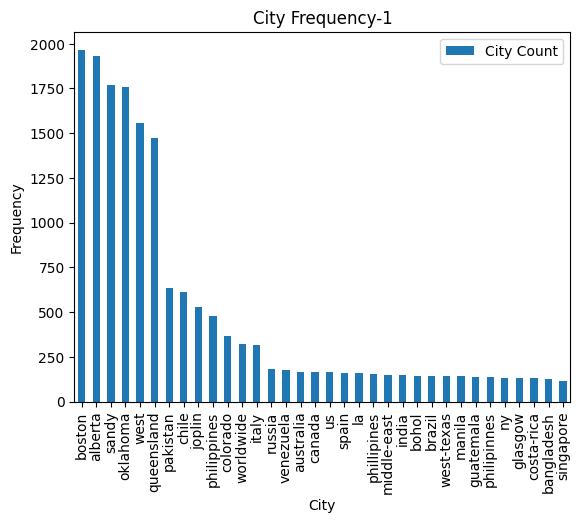

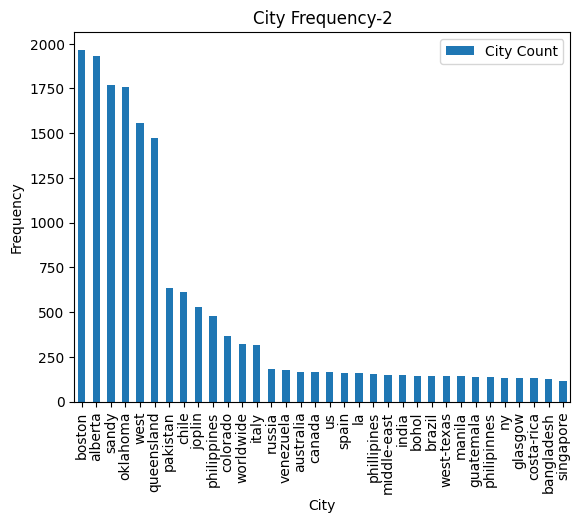

In [21]:
city_count1 = df1['City'].value_counts()
city_count2 = df2['City'].value_counts()


#graph for df1
city_count1.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.title('City Frequency-1')
plt.legend(['City Count'])
plt.show()

#graph for df2
city_count2.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Frequency')
plt.title('City Frequency-2')
plt.legend(['City Count'])
plt.show()




In [22]:
source_count1 = df1['source'].value_counts()
output_count1 = df1['Output'].value_counts()

source_count2 = df2['source'].value_counts()
output_count2 = df2['Output'].value_counts()



In [23]:
#most trustable source
source_ones1 = df1.groupby('source')['Output'].sum()
source_ones2 = df2.groupby('source')['Output'].sum()

mis1 = source_ones1.idxmax()
mis2 = source_ones2.idxmax()




In [24]:
#text_cleaning function
import re

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)  
    text = re.sub(r'@\w+', '', text)            
    text = re.sub(r'#', '', text)               
    text = re.sub(r'[^a-zA-Z\s]', '', text)     
    return text

In [29]:
df1

,id,event,source,text,lang,lang_conf,class_label,lang_encoded,City,Output,City_encoded,lang_encoder
1,323888809920061440,2013_boston_bombings-ontopic,crisislext6,@LilyUnaSmith I'm like 2 miles away. We always...,en,1,not_informative,8,boston,1,4,8
2,324135174038224896,2013_boston_bombings-ontopic,crisislext6,RT @NBCSN: BOSTON MARATHON EXPLOSIONS: 1st exp...,en,1,informative,8,boston,0,4,8
3,327287194735751168,2013_west_texas,crisislext6,Make that 5 co-workers thanks to Bailee.,en,1,not_informative,8,west,1,31,8
5,302473587720347648,2013_russia_meteor_en-mixed,crisislext26,RT @dimaruru: Благодаря Путину до земли долете...,ru,1,informative,35,russia,0,25,35
7,338400443011055616,2013_oklahoma_tornado-ontopic,crisislext6,My wish for you is that this life becomes all ...,en,1,not_informative,8,oklahoma,1,19,8
...,...,...,...,...,...,...,...,...,...,...,...,...
32881,350575242445455360,2013_alberta_floods-ontopic,crisislext6,I WANT TO WATCH WORLD WAR Z AGAIN!,en,1,not_informative,8,alberta,1,0,8
32882,348440372810235904,2013_alberta_floods-ontopic,crisislext6,RT @Kage_99: FYI Non-Canadian followers:\Edmon...,en,1,informative,8,alberta,0,0,8
32883,323975625402626048,2013_boston_bombings-ontopic,crisislext6,@Cmdr_Hadfield: Tonight's Finale: A somber Spr...,en,1,informative,8,boston,0,4,8
32886,263100897456971776,2012_sandy_hurricane-ontopic,crisislext6,Hurricane sandy. Proof that God hates the Yank...,en,1,informative,8,sandy,0,26,8


In [30]:
df2

,id,event,source,text,lang,lang_conf,class_label,lang_encoded,City,Output,City_encoded,lang_encoder
1,323888809920061440,2013_boston_bombings-ontopic,crisislext6,@LilyUnaSmith I'm like 2 miles away. We always...,en,1,not_informative,8,boston,1,4,8
2,324135174038224896,2013_boston_bombings-ontopic,crisislext6,RT @NBCSN: BOSTON MARATHON EXPLOSIONS: 1st exp...,en,1,informative,8,boston,0,4,8
3,327287194735751168,2013_west_texas,crisislext6,Make that 5 co-workers thanks to Bailee.,en,1,not_informative,8,west,1,31,8
5,302473587720347648,2013_russia_meteor_en-mixed,crisislext26,RT @dimaruru: Благодаря Путину до земли долете...,ru,1,informative,35,russia,0,25,35
7,338400443011055616,2013_oklahoma_tornado-ontopic,crisislext6,My wish for you is that this life becomes all ...,en,1,not_informative,8,oklahoma,1,19,8
...,...,...,...,...,...,...,...,...,...,...,...,...
32881,350575242445455360,2013_alberta_floods-ontopic,crisislext6,I WANT TO WATCH WORLD WAR Z AGAIN!,en,1,not_informative,8,alberta,1,0,8
32882,348440372810235904,2013_alberta_floods-ontopic,crisislext6,RT @Kage_99: FYI Non-Canadian followers:\Edmon...,en,1,informative,8,alberta,0,0,8
32883,323975625402626048,2013_boston_bombings-ontopic,crisislext6,@Cmdr_Hadfield: Tonight's Finale: A somber Spr...,en,1,informative,8,boston,0,4,8
32886,263100897456971776,2012_sandy_hurricane-ontopic,crisislext6,Hurricane sandy. Proof that God hates the Yank...,en,1,informative,8,sandy,0,26,8


In [43]:
#feature extraction
vectorizer = TfidfVectorizer(max_features=5000)
t1 = vectorizer.fit_transform(df1['text'].apply(clean_text))
y1 = df1['Output']

t2= vectorizer.fit_transform(df2['text'].apply(clean_text))
y2 = df2['Output']


e1 = vectorizer.fit_transform(df1['event'].apply(clean_text))
e1_sparse = csr_matrix(e1)

e2 = vectorizer.fit_transform(df2['event'].apply(clean_text))
e2_sparse = csr_matrix(e2)

encoder_lang = OneHotEncoder()
X_lang1 = encoder_lang.fit_transform(df1[['lang']]) 
X_lang_sparse1 = csr_matrix(X_lang1)

X_lang2 = encoder_lang.fit_transform(df2[['lang']]) 
X_lang_sparse2 = csr_matrix(X_lang2)

ct1 = vectorizer.fit_transform(df1['City'].apply(clean_text))
ct2 = vectorizer.fit_transform(df2['City'].apply(clean_text))

t = vstack([t1, t2])
e = vstack([e1, e2])
ct = vstack([ct1, ct2])
Xlang = vstack([csr_matrix(X_lang1), csr_matrix(X_lang2)])
X = hstack([t, e, Xlang, ct])
y = pd.concat([df1['Output'], df2['Output']], axis=0).reset_index(drop=True)

In [46]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_Test:", y_test.shape)


Shape of X_train: (26926, 5117)
Shape of y_train: (26926,)
Shape of X_test: (6732, 5117)
Shape of y_Test: (6732,)


In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
Ocean_hazard = RandomForestClassifier(n_estimators=100, random_state=42)
Ocean_hazard.fit(X_train, y_train)
y_pred = Ocean_hazard.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)



Accuracy: 0.9860368389780154
Precision: 0.9860300073870544
Recall: 0.9860368389780154
F1 Score: 0.9860325582937445
Confusion Matrix:
 [[4365   44]
 [  50 2273]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4409
           1       0.98      0.98      0.98      2323

    accuracy                           0.99      6732
   macro avg       0.98      0.98      0.98      6732
weighted avg       0.99      0.99      0.99      6732



In [52]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from scipy.sparse import hstack, vstack, csr_matrix
import joblib
import numpy as np


def clean_text(text):
    return str(text).lower().strip()


vectorizer_text = TfidfVectorizer(max_features=5000)
t1 = vectorizer_text.fit_transform(df1['text'].apply(clean_text))
t2 = vectorizer_text.transform(df2['text'].apply(clean_text))
t = vstack([t1, t2])
text_features = vectorizer_text.get_feature_names_out()


vectorizer_event = TfidfVectorizer(max_features=500)
e1 = vectorizer_event.fit_transform(df1['event'].apply(clean_text))
e2 = vectorizer_event.transform(df2['event'].apply(clean_text))
e = vstack([e1, e2])
event_features = vectorizer_event.get_feature_names_out()

vectorizer_city = TfidfVectorizer(max_features=500)
ct1 = vectorizer_city.fit_transform(df1['City'].apply(clean_text))
ct2 = vectorizer_city.transform(df2['City'].apply(clean_text))
ct = vstack([ct1, ct2])
city_features = vectorizer_city.get_feature_names_out()


encoder_lang = OneHotEncoder()
X_lang1 = encoder_lang.fit_transform(df1[['lang']])
X_lang2 = encoder_lang.transform(df2[['lang']])
Xlang = vstack([csr_matrix(X_lang1), csr_matrix(X_lang2)])
lang_features = encoder_lang.get_feature_names_out(['lang'])


X = hstack([t, e, Xlang, ct])
y = pd.concat([df1['Output'], df2['Output']], axis=0).reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Ocean_hazard = RandomForestClassifier(n_estimators=100, random_state=42)
Ocean_hazard.fit(X_train, y_train)


y_pred = Ocean_hazard.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", report)


feature_names = list(text_features) + list(event_features) + list(lang_features) + list(city_features)


importances = Ocean_hazard.feature_importances_
indices = np.argsort(importances)[-20:]  

print("\nTop 20 important features:")
for i in indices:
    print(feature_names[i], ":", importances[i])


joblib.dump(Ocean_hazard, "Ocean_hazard.pkl")
joblib.dump(vectorizer_text, "vectorizer_text.pkl")
joblib.dump(vectorizer_event, "vectorizer_event.pkl")
joblib.dump(vectorizer_city, "vectorizer_city.pkl")
joblib.dump(encoder_lang, "encoder_lang.pkl")


Accuracy: 0.9860368389780154
Precision: 0.9860341838510629
Recall: 0.9860368389780154
F1 Score: 0.9860354153928947
Confusion Matrix:
 [[4363   46]
 [  48 2275]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      4409
           1       0.98      0.98      0.98      2323

    accuracy                           0.99      6732
   macro avg       0.98      0.98      0.98      6732
weighted avg       0.99      0.99      0.99      6732


Top 20 important features:
oklahoma : 0.007040766204806894
of : 0.007087582241274201
my : 0.007108751566908369
queensland : 0.0078112875751906695
explosion : 0.008316744527450813
yycflood : 0.008374798662551605
you : 0.008482258594208335
2013_queensland_floods : 0.008933353532776672
sandy : 0.009425051213316271
boston : 0.00981011218701307
tornado : 0.010825355842427928
in : 0.013489606800010072
2013_west_texas : 0.013725099169648272
flood : 0.014178147705380586
west : 0.01699276139

['encoder_lang.pkl']

In [5]:
Ocean_hazardnn = MLPClassifier(hidden_layer_sizes=(128,64), max_iter=500, random_state=42)
Ocean_hazardnn.fit(X_train, y_train)

y_prednn = Ocean_hazardnn.predict(X_test)
accuracynn = accuracy_score(y_test, y_prednn)
precisionnn = precision_score(y_test, y_prednn, average='weighted')
recallnn = recall_score(y_test, y_prednn, average='weighted')
f1nn = f1_score(y_test, y_prednn, average='weighted')
cmnn = confusion_matrix(y_test, y_prednn)
reportnn = classification_report(y_test, y_prednn)
print('Using Neural Network')

print("Accuracy:", accuracynn)
print("Precision:", precisionnn)
print("Recall:", recallnn)
print("F1 Score:", f1nn)
print("Confusion Matrix:\n", cmnn)
print("Classification Report:\n", reportnn)

NameError: name 'MLPClassifier' is not defined

In [8]:

import cv2
import sounddevice as sd
import wavio
import numpy as np
import joblib
import os

# --- CONFIGURATION ---
MODEL_PATH = "Ocean_Hazard.pkl"
IMAGE_FILE = "hazard_image.jpg"
AUDIO_FILE = "hazard_voice.wav"
TARGET_FEATURES = 5138   # Features expected by your model
AUDIO_DURATION = 5       # seconds
AUDIO_FREQ = 44100       # Hz

# --- CAMERA FUNCTION ---
def capture_image(filename=IMAGE_FILE):
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Error: Cannot access camera.")
        return None
    
    print("Camera accessed. Press 'q' to capture an image.")
    while True:
        ret, frame = cap.read()
        if not ret:
            print("Error: Failed to grab frame.")
            break
        
        cv2.imshow('Camera Feed', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            cv2.imwrite(filename, frame)
            print(f"Image saved: {filename}")
            break
    
    cap.release()
    cv2.destroyAllWindows()
    return filename

# --- AUDIO FUNCTION ---
def record_audio(filename=AUDIO_FILE, duration=AUDIO_DURATION, freq=AUDIO_FREQ):
    print(f"Recording audio for {duration} seconds...")
    recording = sd.rec(int(duration * freq), samplerate=freq, channels=2)
    sd.wait()
    wavio.write(filename, recording, freq, sampwidth=2)
    print(f"Audio saved: {filename}")
    return filename

# --- MODEL FUNCTIONS ---
def load_model(path=MODEL_PATH):
    if not os.path.exists(path):
        print(f"Error: Model file {path} not found.")
        return None
    model = joblib.load(path)
    print("Model loaded successfully.")
    print("Model expects features:", model.n_features_in_)
    return model

def preprocess_image(image_path, target_features=TARGET_FEATURES):
    # Load image in grayscale
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Error: Unable to load image.")
        return None
    
    # Resize to approximate square (example: 72x72)
    img = cv2.resize(img, (72, 72))
    
    # Flatten and normalize
    img_flat = img.flatten() / 255.0
    
    # Pad or truncate to match target features
    if len(img_flat) < target_features:
        img_flat = np.pad(img_flat, (0, target_features - len(img_flat)), 'constant')
    else:
        img_flat = img_flat[:target_features]
    
    return img_flat.reshape(1, -1)

def predict(model, image_path):
    data = preprocess_image(image_path)
    if data is None:
        return None
    prediction = model.predict(data)
    return prediction

# --- MAIN PIPELINE ---
def main():
    model = load_model()
    if model is None:
        return
    
    # Capture image
    image_file = capture_image()
    if image_file is None:
        return
    
    # Record audio
    audio_file = record_audio()
    
    # Predict using captured image
    result = predict(model, image_file)
    if result is not None:
        print("Prediction result:", result)
    else:
        print("Prediction failed.")

# Run the pipeline
if __name__ == "__main__":
    main()


Model loaded successfully.
Model expects features: 5138
Camera accessed. Press 'q' to capture an image.
Image saved: hazard_image.jpg
Recording audio for 5 seconds...
Audio saved: hazard_voice.wav
Prediction result: [0]
